Computational Exercise 1
--

In [5]:
using Distributions
using PyPlot

In [18]:
function sim(n=200, ρ=0.5)
    v1 = rand(Uniform(0,sqrt(12)),n)
    v2 = rand(Uniform(0,sqrt(12)),n)
    X = ones(200,3)
    X[:,2] = v1
    X[:,3] = sqrt(1-ρ^2)*v2 + ρ*v1
    y = 1 .+ X[:,2] + X[:,3] + exp(X*[0.1; 0.1; 0.1]) .* rand(Normal(),n)
    
    β = (X'X)\(X'y)
    e = y - X*β
    s = sum(e.^2)/(n-3)
    Qxxinv = inv(1/n*X'X)
    h = diag(X*inv(X'X)*X')
    
    Ωtilde = zeros(3,3)
    Ωhat = zeros(3,3)
    
    for i in 1:n
        Ωtilde += X[i,:]*X[i,:]'*(1-h[i])^-1*e[i]^2
        Ωhat += X[i,:]*X[i,:]'*(1-h[i])^(-1/2)*e[i]^2
    end
    
    Ωtilde = Ωtilde/n
    Ωhat = Ωhat/n
    
    return vcat((β[2]-1)/sqrt(Qxxinv[2,2]*s/n), (β[2]-1)/sqrt((Qxxinv*Ωtilde*Qxxinv)[2,2]/n), 
    (β[2]-1)/sqrt((Qxxinv*Ωhat*Qxxinv)[2,2]/n))
end

sim (generic function with 3 methods)

In [22]:
simulations = SharedArray(Float64, 10000, 3)
for i in 1:10000
    simulations[i,:] = sim()
end;

In [23]:
quantiles = [100, 250, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 9500, 9750, 9850]
homo = sort(simulations[:,1])
hetero1 = sort(simulations[:,2])
hetero2 = sort(simulations[:,3])
vcat(homo[quantiles]', hetero1[quantiles]', hetero2[quantiles]', quantile(Normal(),quantiles/10000)')'

15×4 Array{Float64,2}:
 -2.35177     -2.39181     -2.40237     -2.32635 
 -1.99172     -2.02619     -2.03522     -1.95996 
 -1.6809      -1.69107     -1.69952     -1.64485 
 -1.26842     -1.28869     -1.29463     -1.28155 
 -0.819827    -0.827012    -0.830834    -0.841621
 -0.516588    -0.518114    -0.520702    -0.524401
 -0.232706    -0.235139    -0.23635     -0.253347
  0.00700251   0.00728885   0.00732268   0.0     
  0.247623     0.250513     0.251697     0.253347
  0.515299     0.521572     0.524301     0.524401
  0.831546     0.843652     0.847714     0.841621
  1.27058      1.28438      1.29034      1.28155 
  1.6725       1.68576      1.69281      1.64485 
  1.97987      2.02102      2.03061      1.95996 
  2.21877      2.22615      2.23682      2.17009 

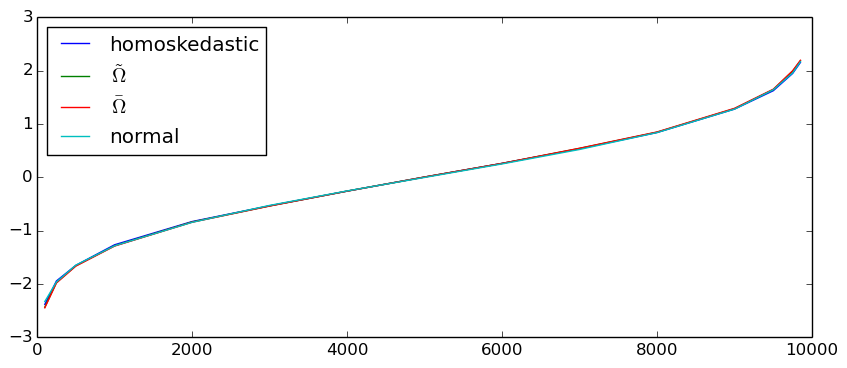

In [23]:
figure(figsize=[10, 4])
plot(quantiles, homo[quantiles], label="homoskedastic")
plot(quantiles, hetero1[quantiles], label=L"\tilde{\Omega}")
plot(quantiles, hetero2[quantiles], label=L"\bar{\Omega}")
plot(quantiles, quantile(Normal(),quantiles/10000), label="normal")
legend(loc="upper left");

Ignoring the variance structure does not matter a lot!
Computational Exercise 2
--

In [24]:
function sim2(n=200, ρ=0.5)
    v1 = rand(Uniform(0,sqrt(12)),n)
    v2 = rand(Uniform(0,sqrt(12)),n)
    X = ones(n,2)
    y = zeros(n)
    
    errory = rand(Normal(),n)
    errorx = rand(Normal(),n)
    
    y[1] = errory[1]
    X[1,2] = errorx[1]
    
    for i in 2:n
        y[i] = 0.98*y[i-1] + errory[i]
        X[i,2] = 0.97*X[i-1,2] + errorx[i]
    end
    
    β = (X'X)\(X'y)
    e = y - X*β
    s = sum(e.^2)/(n-2)
    Qxxinv = inv(1/n*X'X)

    return β[2]/sqrt(Qxxinv[2,2]*s/n)
end

sim2 (generic function with 3 methods)

In [25]:
simulations = SharedArray(Float64, 10000, 1)
@sync @parallel for i in 1:10000
    simulations[i,:] = sim2()
end;

In [26]:
quantiles = [100, 250, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 9500, 9750, 9850]
homo = sort(simulations[:,1])
vcat(homo[quantiles]', quantile(Normal(),quantiles/10000)')'

15×2 Array{Float64,2}:
 -13.8258    -2.32635 
 -11.3827    -1.95996 
  -9.30108   -1.64485 
  -7.17877   -1.28155 
  -4.63246   -0.841621
  -2.82088   -0.524401
  -1.40235   -0.253347
   0.039835   0.0     
   1.43412    0.253347
   2.83154    0.524401
   4.57872    0.841621
   7.0089     1.28155 
   9.38118    1.64485 
  11.2905     1.95996 
  12.7385     2.17009 

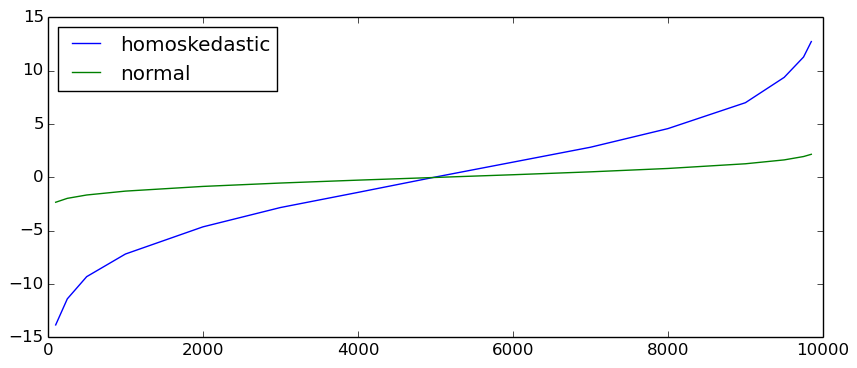

In [27]:
figure(figsize=[10, 4])
plot(quantiles, homo[quantiles], label="homoskedastic")
plot(quantiles, quantile(Normal(),quantiles/10000), label="normal")
legend(loc="bottom right");

The t-test rejects in about 70 % of the simulations, given $c=1.96$. The researcher who beliefs the linear regression model would most likely find that $\beta_1$ is significantly different than zero, which is of course nonsense given the data generating process. The problems is that the sample is not iid, in fact we have very persistent autoregression. The sign of $\beta$ really just depends on the the errors that generated $x$ and $y$, which is close to flipping a coin.